### Import dependencies

In [35]:
# Imports (Non exhaustive)
import numpy as np    
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow API new structure for Tensorflow v2.15.0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Data Preparation

In [56]:
# Directories definition
train_path = "C:/Users/user/Desktop/Chest Xray Classifier/dataset/train"
test_path = "C:/Users/user/Desktop/Chest Xray Classifier/dataset/test"
val_path = "C:/Users/user/Desktop/Chest Xray Classifier/dataset/val"

# Basic parameters (image dimension and batch size)
batch_size = 16
img_height = 500
img_width = 500

# Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Data Generator for Training data set
# Randomly augment training data
image_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

# Image Data Generator for Test/Validation data set
test_data_gen = ImageDataGenerator(rescale=1./255)


# Load data
train = image_gen.flow_from_directory(train_path,
                                      target_size=(img_height, img_width),
                                      color_mode='grayscale',
                                      shuffle=False,
                                      class_mode='binary',
                                      batch_size=batch_size)

test = test_data_gen.flow_from_directory(test_path,
                                          target_size=(img_height, img_width),
                                          color_mode='grayscale',
                                          shuffle=False, 
                                          class_mode='binary',
                                          batch_size=batch_size)

valid = test_data_gen.flow_from_directory(val_path,
                                          target_size=(img_height, img_width),
                                          color_mode='grayscale',
                                          class_mode='binary',
                                          batch_size=batch_size)


Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


### Model 

In [61]:
# Model Architecture (Input->CNN->Flat->ANN->Output)
cnn = Sequential()

# Data augmentation layer (part of model)
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.Rescaling(1./255),
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomZoom(0.2),
#     tf.keras.layers.RandomRotation(0.2)
# ])
# cnn.add(data_augmentation)

# Convolution and Pooling Layers
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten 
cnn.add(Flatten())

# Fully-connected Neural Network Layers
cnn.add(Dense(activation='relu', units = 128))
cnn.add(Dense(activation='relu', units = 64))
cnn.add(Dense(activation='sigmoid', units = 1))

cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Regularization callbacks
early = EarlyStopping(monitor="val_loss", mode="min", patience=1) # Patience: no. of epochs to run after monitored parameter stops changing
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.3, min_lr=0.00001)
callbacks_ls = [early, learning_rate_reduction] 

# Class weights for unbalanced datasets
# Assign higher weights to the minority class, reduce bias towards majority class
# Calculate proportion, invert it as a counter-bias
# from sklearn.utils.class_weight import compute_class_weight
# weights = compute_class_weight('balanced', np.unique(train.class_names))
# class_weight_val = dict(zip(np.unique(train.class_names), weights))
# #print(class_weight_val)

### Training

Epoch 1/10
262/262 [==============================] - 451s 2s/step - loss: 0.6471 - accuracy: 0.7288 - val_loss: 0.4763 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 2/10
262/262 [==============================] - 477s 2s/step - loss: 0.5615 - accuracy: 0.7576 - val_loss: 0.3441 - val_accuracy: 0.8317 - lr: 0.0010
Epoch 3/10
262/262 [==============================] - 482s 2s/step - loss: 0.4619 - accuracy: 0.8108 - val_loss: 0.3203 - val_accuracy: 0.9077 - lr: 0.0010
Epoch 4/10
262/262 [==============================] - 481s 2s/step - loss: 0.3340 - accuracy: 0.8683 - val_loss: 0.2645 - val_accuracy: 0.8923 - lr: 0.0010
Epoch 5/10
262/262 [==============================] - 481s 2s/step - loss: 0.2779 - accuracy: 0.8943 - val_loss: 0.2420 - val_accuracy: 0.9077 - lr: 0.0010
Epoch 6/10
262/262 [==============================] - 481s 2s/step - loss: 0.2386 - accuracy: 0.9060 - val_loss: 0.1704 - val_accuracy: 0.9337 - lr: 0.0010
Epoch 7/10
262/262 [==============================] - 490s 2s/st

<AxesSubplot:>

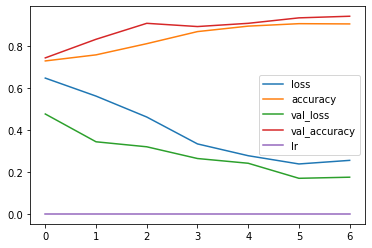

In [62]:
# Train model (run this cell to train)
# cnn.fit(train, epochs=30, validation_data=valid, class_weight=class_weight_val, callbacks=callbacks_ls)
cnn.fit(train, epochs=10, validation_data=valid, callbacks=callbacks_ls)
# Training metric visualization
pd.DataFrame(cnn.history.history).plot()

### Model Evaluation

39/39 [==============================] - 15s 377ms/step - loss: 0.4205 - accuracy: 0.8253
Test Accuracy:  82.53205418586731 %
39/39 [==============================] - 16s 400ms/step
              precision    recall  f1-score   support

      NORMAL       0.89      0.61      0.72       234
   PNEUMONIA       0.80      0.95      0.87       390

    accuracy                           0.83       624
   macro avg       0.85      0.78      0.80       624
weighted avg       0.84      0.83      0.82       624



<AxesSubplot:>

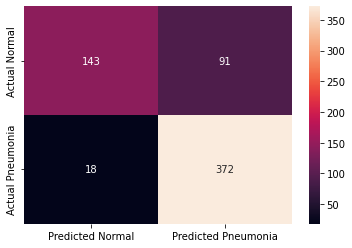

In [68]:
# Model evaluation
test_model = cnn.evaluate(test)
test_accu = test_model[1] * 100
print('Test Accuracy: ', test_accu, '%')

# Assign binary classes to prediction output (Sigmoid: 0 < output < 1)
prediction = cnn.predict(test, verbose=1)
prediction_bin = prediction.copy()
prediction_bin[prediction_bin <=0.5 ] = 0
prediction_bin[prediction > 0.5] = 1

# Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
con_mat = pd.DataFrame(data=confusion_matrix(test.classes, prediction_bin, labels=[0, 1]),
                       index=["Actual Normal", "Actual Pneumonia"],
                       columns=["Predicted Normal", "Predicted Pneumonia"])
print(classification_report(y_true=test.classes, y_pred=prediction_bin, target_names=['NORMAL','PNEUMONIA']))

import seaborn as sns
sns.heatmap(con_mat, annot=True, fmt='d')


### Image Visualization

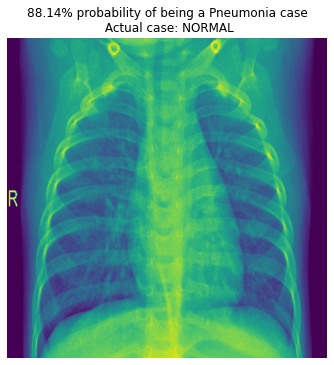

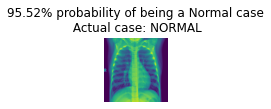

In [78]:
# Extract images from test data iterator without shuffling sequence
test.reset()
x = np.concatenate([test.next()[0] for i in range(test.__len__())])  # Images
y = np.concatenate([test.next()[1] for i in range(test.__len__())])  # Labels

dict = {0: 'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20, 20))
for i in range(0+228, 2+228):
    plt.subplot(3, 3, (i-228)+1)
    if prediction[i, 0] >= 0.5:
        out = ('{:.2%} probability of being a Pneumonia case'.format(prediction[i][0]))
    else:
        out = ('{:.2%} probability of being a Normal case'.format(1-prediction[i][0]))
    plt.title(out + "\n Actual case: " + dict.get(y[i]))
    plt.imshow(np.squeeze(x[i]))
    plt.axis('off')
    plt.show()